In [41]:
import numpy as np
import matplotlib.pyplot as plt
import json
import requests
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import (
    StandardScaler,
)  # May be needed if student wants to scale within function, though data is pre-scaled
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, classification_report
import os

SEED = 1337
np.random.seed(SEED)

# Dataset filename provided by the teacher
dataset_filename = "clean_label_eval_dataset.npz"

# Attack Hyperparameters
N_NEIGHBORS = 12  # Number of neighbors from perturbing class to modify
EPSILON_CROSS = 0.4  # Perturbation magnitude (how far to push neighbors)

htb_green = "#9fef00"
node_black = "#141d2b"
hacker_grey = "#a4b1cd"
white = "#ffffff"
azure = "#0086ff"
nugget_yellow = "#ffaf00"
malware_red = "#ff3e3e"
vivid_purple = "#9f00ff"
aquamarine = "#2ee7b6"

# Configure plot styles
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams.update(
    {
        "figure.facecolor": node_black,
        "axes.facecolor": node_black,
        "axes.edgecolor": hacker_grey,
        "axes.labelcolor": white,
        "text.color": white,
        "xtick.color": hacker_grey,
        "ytick.color": hacker_grey,
        "grid.color": hacker_grey,
        "grid.alpha": 0.1,
        "legend.facecolor": node_black,
        "legend.edgecolor": hacker_grey,
        "legend.frameon": True,
        "legend.framealpha": 0.8,
        "legend.labelcolor": white,
        "figure.figsize": (12, 7),
    }
)


In [42]:
try:
    data = np.load(dataset_filename)
    X_train = data["Xtr"]
    y_train = data["ytr"]
    X_test = data["Xte"]
    y_test = data["yte"]
    # Load target index - make sure it's an integer scalar
    target_index = int(data["target_idx"].item())
    data.close()
    print("Data loaded successfully from .npz file.")
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    print(f"Target Point Index: {target_index}")

    # Determine target class and infer perturbing/misclassify-as class based on common scenarios
    if target_index < 0 or target_index >= len(y_train):
        raise ValueError(
            f"Loaded target_index {target_index} is out of bounds for y_train."
        )

    TARGET_CLASS = int(y_train[target_index])
    if TARGET_CLASS == 2:
        PERTURBING_CLASS = 1
        MISCLASSIFY_AS_CLASS = 1
    elif TARGET_CLASS == 0:
        PERTURBING_CLASS = 1
        MISCLASSIFY_AS_CLASS = 1
    elif TARGET_CLASS == 1:
        PERTURBING_CLASS = 0
        MISCLASSIFY_AS_CLASS = 0
    else:
        raise ValueError(
            f"Unexpected TARGET_CLASS {TARGET_CLASS} derived from index {target_index}"
        )

    print(f"Target Point True Class (TARGET_CLASS): {TARGET_CLASS}")
    print(f"Inferred Perturbing Class (PERTURBING_CLASS): {PERTURBING_CLASS}")
    print(
        f"Required Misclassification Class (MISCLASSIFY_AS_CLASS): {MISCLASSIFY_AS_CLASS}"
    )
    X_target_point = X_train[target_index]

except FileNotFoundError:
    print(f"{malware_red}Error:{white} Dataset file '{dataset_filename}' not found.")
    print("Make sure the .npz data file is in the correct directory.")
    raise
except KeyError as e:
    print(
        f"{malware_red}Error:{white} Could not find expected key '{e}' in '{dataset_filename}'."
    )
    raise
except Exception as e:
    print(f"{malware_red}An unexpected error occurred during data loading:{white} {e}")
    raise


Data loaded successfully from .npz file.
X_train shape: (1260, 2)
y_train shape: (1260,)
X_test shape: (540, 2)
y_test shape: (540,)
Target Point Index: 334
Target Point True Class (TARGET_CLASS): 2
Inferred Perturbing Class (PERTURBING_CLASS): 1
Required Misclassification Class (MISCLASSIFY_AS_CLASS): 1


In [43]:
def plot_data_multi(
    X,
    y,
    title="Multi-Class Dataset Visualization",
    highlight_indices=None,
    highlight_markers=None,
    highlight_colors=None,
    highlight_labels=None,
):
    """Plots 2D multi-class data with optional highlighting."""
    plt.figure(figsize=(12, 7))
    class_colors = [azure, nugget_yellow, malware_red]
    unique_classes = np.unique(y)
    max_class_idx = int(np.max(unique_classes)) if len(unique_classes) > 0 else -1
    if max_class_idx >= len(class_colors):
        class_colors.extend([hacker_grey] * (max_class_idx + 1 - len(class_colors)))
    cmap_multi = plt.cm.colors.ListedColormap(class_colors)

    plt.scatter(
        X[:, 0],
        X[:, 1],
        c=y,
        cmap=cmap_multi,
        edgecolors=node_black,
        s=50,
        alpha=0.7,
        zorder=1,
    )

    highlight_handles = []
    if highlight_indices is not None and len(highlight_indices) > 0:
        num_highlights = len(highlight_indices)
        _markers = highlight_markers if highlight_markers else ["o"] * num_highlights
        _colors = (
            highlight_colors if highlight_colors else [vivid_purple] * num_highlights
        )
        _labels = highlight_labels if highlight_labels else [""] * num_highlights
        for i, idx in enumerate(highlight_indices):
            if not (0 <= idx < X.shape[0]):
                continue
            marker = _markers[i % len(_markers)]
            edge_color = _colors[i % len(_colors)]
            label = _labels[i % len(_labels)]
            point_class = int(y[idx])
            face_color = (
                class_colors[point_class]
                if 0 <= point_class < len(class_colors)
                else hacker_grey
            )
            z_order = 3 if marker == "P" else 2
            plt.scatter(
                X[idx, 0],
                X[idx, 1],
                facecolors=face_color,
                edgecolors=edge_color,
                marker=marker,
                s=180,
                linewidths=2,
                alpha=1.0,
                zorder=z_order,
            )
            if label:
                highlight_handles.append(
                    plt.Line2D(
                        [0],
                        [0],
                        marker=marker,
                        color="w",
                        label=label,
                        markerfacecolor=face_color,
                        markeredgecolor=edge_color,
                        markersize=10,
                        linestyle="None",
                        markeredgewidth=1.5,
                    )
                )

    plt.title(title, fontsize=16, color=htb_green)
    plt.xlabel("Feature 1 (Standardized)", fontsize=12)
    plt.ylabel("Feature 2 (Standardized)", fontsize=12)
    class_handles = []
    unique_classes_present = sorted(np.unique(y))
    for class_idx in unique_classes_present:
        int_class_idx = int(class_idx)
        if 0 <= int_class_idx < len(class_colors):
            class_handles.append(
                plt.Line2D(
                    [0],
                    [0],
                    marker="o",
                    color="w",
                    label=f"Class {int_class_idx}",
                    markersize=10,
                    markerfacecolor=class_colors[int_class_idx],
                    markeredgecolor=node_black,
                    linestyle="None",
                )
            )
    all_handles = class_handles + highlight_handles
    if all_handles:
        plt.legend(handles=all_handles, title="Classes & Points")
    plt.grid(True, color=hacker_grey, linestyle="--", linewidth=0.5, alpha=0.3)
    plt.show()


def plot_decision_boundary_multi(
    X,
    y,
    model,
    title="Decision Boundary",
    highlight_indices=None,
    highlight_markers=None,
    highlight_colors=None,
    highlight_labels=None,
):
    """Plots decision boundaries for a multi-class model."""
    plt.figure(figsize=(12, 7))
    class_colors = [azure, nugget_yellow, malware_red]
    light_colors = [c + "60" for c in class_colors]  # Add alpha for contour fill
    max_class_data = int(np.max(y)) if len(y) > 0 else -1
    if max_class_data >= len(class_colors):
        class_colors.extend([hacker_grey] * (max_class_data + 1 - len(class_colors)))
        light_colors.extend(
            [hacker_grey + "60"] * (max_class_data + 1 - len(light_colors))
        )

    h = 0.02  # Mesh step size
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    mesh_points = np.c_[xx.ravel(), yy.ravel()]

    try:
        Z = model.predict(mesh_points)
        Z = Z.reshape(xx.shape)
        max_class_pred = int(np.max(Z)) if Z.size > 0 else -1
        if max_class_pred >= len(class_colors):
            # Need to ensure enough colors for predicted classes on mesh
            needed = max_class_pred + 1
            if needed > len(class_colors):
                class_colors.extend([hacker_grey] * (needed - len(class_colors)))
                light_colors.extend([hacker_grey + "60"] * (needed - len(light_colors)))

        cmap_light = plt.cm.colors.ListedColormap(light_colors[: max_class_pred + 1])
        cmap_bold = plt.cm.colors.ListedColormap(class_colors[: max_class_data + 1])

        plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6, zorder=0)
        plt.scatter(
            X[:, 0],
            X[:, 1],
            c=y,
            cmap=cmap_bold,
            edgecolors=node_black,
            s=50,
            alpha=0.8,
            zorder=1,
        )

        # Plot highlighted points
        highlight_handles = []
        if highlight_indices is not None and len(highlight_indices) > 0:
            num_highlights = len(highlight_indices)
            _markers = (
                highlight_markers if highlight_markers else ["o"] * num_highlights
            )
            _colors = (
                highlight_colors
                if highlight_colors
                else [vivid_purple] * num_highlights
            )
            _labels = highlight_labels if highlight_labels else [""] * num_highlights
            for i, idx in enumerate(highlight_indices):
                if not (0 <= idx < X.shape[0]):
                    continue
                marker = _markers[i % len(_markers)]
                edge_color = _colors[i % len(_colors)]
                label = _labels[i % len(_labels)]
                point_class = int(y[idx])
                face_color = (
                    class_colors[point_class]
                    if 0 <= point_class < len(class_colors)
                    else hacker_grey
                )
                z_order = 3 if marker == "P" else 2
                plt.scatter(
                    X[idx, 0],
                    X[idx, 1],
                    facecolors=face_color,
                    edgecolors=edge_color,
                    marker=marker,
                    s=180,
                    linewidths=2,
                    alpha=1.0,
                    zorder=z_order,
                )
                if label:
                    highlight_handles.append(
                        plt.Line2D(
                            [0],
                            [0],
                            marker=marker,
                            color="w",
                            label=label,
                            markerfacecolor=face_color,
                            markeredgecolor=edge_color,
                            markersize=10,
                            linestyle="None",
                            markeredgewidth=1.5,
                        )
                    )

        plt.title(title, fontsize=16, color=htb_green)
        plt.xlabel("Feature 1 (Standardized)", fontsize=12)
        plt.ylabel("Feature 2 (Standardized)", fontsize=12)
        class_handles = []
        unique_classes_present = sorted(np.unique(y))
        for class_idx in unique_classes_present:
            int_class_idx = int(class_idx)
            if 0 <= int_class_idx < len(class_colors):
                class_handles.append(
                    plt.Line2D(
                        [0],
                        [0],
                        marker="o",
                        color="w",
                        label=f"Class {int_class_idx}",
                        markersize=10,
                        markerfacecolor=class_colors[int_class_idx],
                        markeredgecolor=node_black,
                        linestyle="None",
                    )
                )
        all_handles = class_handles + highlight_handles
        if all_handles:
            plt.legend(handles=all_handles, title="Classes & Points")

        plt.grid(True, color=hacker_grey, linestyle="--", linewidth=0.5, alpha=0.3)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.show()

    except Exception as e:
        print(f"{malware_red}Error during plotting decision boundary:{white} {e}")
        plt.figure(figsize=(12, 7))
        plt.scatter(
            X[:, 0],
            X[:, 1],
            c=y,
            cmap=plt.cm.colors.ListedColormap(class_colors),
            edgecolors=node_black,
        )
        plt.title(f"{title} (Plotting Error)", color=malware_red)
        plt.show()


print("Visualization functions defined.")


Visualization functions defined.



--- Visualizing Clean Training Data with Target Point ---


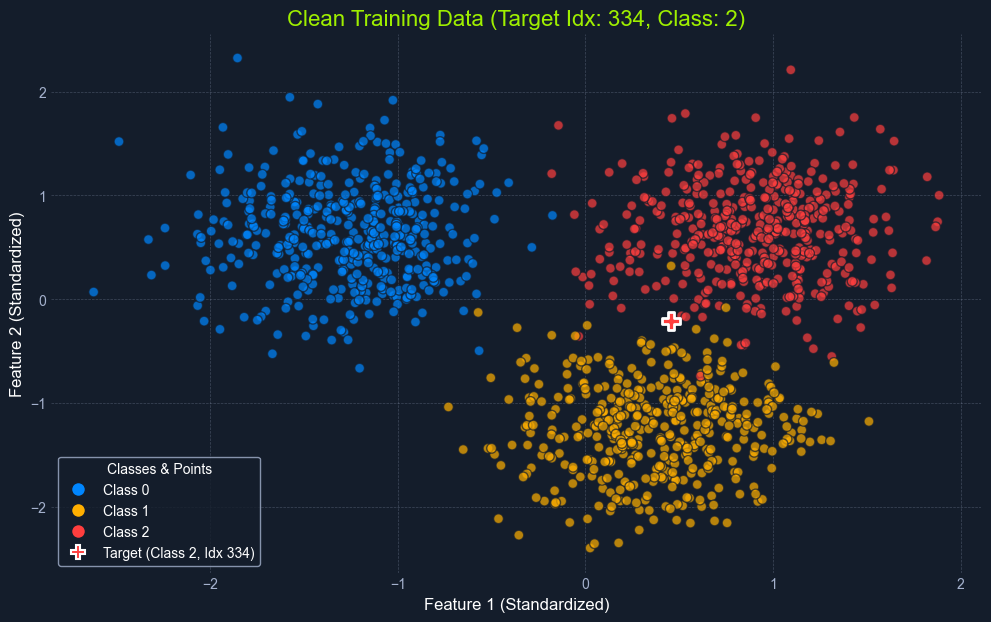

In [44]:
print("\n--- Visualizing Clean Training Data with Target Point ---")
plot_data_multi(
    X_train,
    y_train,
    title=f"Clean Training Data (Target Idx: {target_index}, Class: {TARGET_CLASS})",
    highlight_indices=[target_index],
    highlight_markers=["P"],  # Plus sign for target
    highlight_colors=[white],  # White edge for visibility
    highlight_labels=[f"Target (Class {TARGET_CLASS}, Idx {target_index})"],
)


Download the feature_student.zip file attached to this question, and extract the notebook template and dataset file within it. Using the techniques that have been demonstrated in this section, implement a clean label attack to misclassify Class 2 Index 334 as Class 1, train a model using the provided code, and submit the trained model to the docker instance using the last cell in the notebook. Submit the flag you receive for a valid attack as the answer to this question.

+ Target Point Index: 334
+ Target Point True Class (TARGET_CLASS): 2
+ Inferred Perturbing Class (PERTURBING_CLASS): 1

In [45]:
def perform_clean_label_attack(
    X_train_orig,
    y_train_orig,
    target_idx,
    target_class,
    perturb_class,
    n_neighbors,
    epsilon_cross,
    seed,
):
    np.random.seed(seed)
    base_estimator = LogisticRegression(random_state=seed, C=1.0, solver="liblinear")
    baseline_model_3c = OneVsRestClassifier(base_estimator)
    baseline_model_3c.fit(X_train_orig, y_train_orig)
    print("Baseline OvR model trained successfully.")
    try:
        if (
            hasattr(baseline_model_3c, "estimators_")
            and len(baseline_model_3c.estimators_) == 3
        ):
            estimators_base = baseline_model_3c.estimators_
            # For binary LogisticRegression with liblinear, coef_ is shape (1, n_features) and intercept_ is (1,)
            # We extract them for each of the 3 binary classifiers (0 vs Rest, 1 vs Rest, 2 vs Rest)
            w0_base = estimators_base[0].coef_[0]  # Weight vector for class 0 vs Rest
            b0_base = estimators_base[0].intercept_[0]  # Intercept for class 0 vs Rest
            w1_base = estimators_base[1].coef_[0]  # Weight vector for class 1 vs Rest
            b1_base = estimators_base[1].intercept_[0]  # Intercept for class 1 vs Rest
            w2_base = estimators_base[2].coef_[0]  # Weight vector for class 2 vs Rest
            b2_base = estimators_base[2].intercept_[0]  # Intercept for class 2 vs Rest
            print(
                "Baseline model parameters (w0, b0, w1, b1, w2, b2) extracted successfully."
            )
        else:
            # This might happen if the model didn't fit correctly or classes were dropped
            raise RuntimeError(
                "Could not extract expected number of estimators from baseline OvR model."
            )
    except Exception as e:
        print(f"Error: Failed to extract baseline parameters: {e}")

    # -----------------------------
    print("\n--- Selecting Target Point ---")
    # We use the baseline parameters w0_base, b0_base, w1_base, b1_base extracted earlier
    # Calculate the difference vector and intercept for the 0-vs-1 boundary
    w_diff_01_base = w0_base - w1_base
    b_diff_01_base = b0_base - b1_base
    print(f"Boundary vector (w0-w1): {w_diff_01_base}")
    print(f"Intercept difference (b0-b1): {b_diff_01_base}")

    # Identify indices of all Class 2 points in the original clean training set
    class1_indices_train = np.where(y_train_orig == target_class)[0]

    if len(class1_indices_train) == 0:
        raise ValueError(
            "CRITICAL: No Class 2 points found in the training data. Cannot select target."
        )
    else:
        print(f"Found {len(class1_indices_train)} Class 2 points in the training set.")

    # Get the feature vectors for only the Class 2 points
    X_class1_train = X_train_orig[class1_indices_train]

    # Calculate the decision function f_01(x) = (w0-w1)^T x + (b0-b1) for these Class 1 points
    # A negative value means the point is on the Class 1 side of the 0-vs-1 boundary
    decision_values_01 = X_class1_train @ w_diff_01_base + b_diff_01_base

    # Find indices within the subset of Class 1 points that are correctly classified (f_01 < 0)
    class1_on_correct_side_indices_relative = np.where(decision_values_01 < 0)[0]

    if len(class1_on_correct_side_indices_relative) == 0:
        # This case is unlikely if the baseline model has decent accuracy, but handle it.
        print(
            f"{malware_red}Warning:{white} No Class 2 points found on the expected side (f_01 < 0) of the 0-vs-1 baseline boundary."
        )
        print(
            "Selecting the Class 1 point with the minimum absolute decision value instead."
        )
        # Find index (relative to class1 subset) with the smallest absolute distance to boundary
        target_point_index_relative = np.argmin(np.abs(decision_values_01))
    else:
        # Among the correctly classified points, find the one closest to the boundary
        # This corresponds to the maximum (least negative) decision value
        target_point_index_relative = class1_on_correct_side_indices_relative[
            np.argmax(decision_values_01[class1_on_correct_side_indices_relative])
        ]
    # Map the relative index (within the class1 subset) back to the absolute index in the original X_train_3c array
    #target_point_index_absolute = class1_indices_train[target_point_index_relative]
    #target_point_index_absolute = class1_indices_train[target_idx]

    # Retrieve the target point's features and true label
    X_target = X_train_orig[target_idx]
    y_target = y_train_orig[
        target_idx
    ]  # Should be 2 based on selection logic

    # Sanity Check: Verify the chosen point's class and baseline prediction
    target_baseline_pred = baseline_model_3c.predict(X_target.reshape(1, -1))[0]
    target_decision_value = decision_values_01[target_point_index_relative]

    print(f"\nSelected Target Point Index (absolute): {target_idx}")
    print(f"Target Point Features: {X_target}")
    print(f"Target Point True Label (y_target): {y_target}")
    print(f"Target Point Baseline Prediction: {target_baseline_pred}")
    print(
        f"Target Point Baseline 0-vs-1 Decision Value (f_01): {target_decision_value:.4f}"
    )

    if y_target != 2:
        print(
            f"Error: Selected target point does not have label 2! Check logic."
        )
    if target_baseline_pred != y_target:
        print(
            f"Warning: Baseline model actually misclassifies the chosen target point ({target_baseline_pred}). Attack might trivially succeed or have unexpected effects."
        )
    if target_decision_value >= 0:
        print(
            f"Warning: Selected target point has f_01 >= 0 ({target_decision_value:.4f}), meaning it wasn't on the Class 2 side of the 0-vs-1 boundary. Check logic or baseline model."
        )
    # Visualize the data highlighting the selected target point near the boundary
    print("\n--- Visualizing Training Data with Target Point ---")
    plot_data_multi(
        X_train_orig,
        y_train_orig,
        title="Training Data Highlighting the Target Point (Near Boundary)",
        highlight_indices=[target_idx],
        highlight_markers=["P"],  # 'P' for Plus sign marker (Target)
        highlight_colors=[white],  # White edge color for visibility
        highlight_labels=[f"Target (Class {y_target}, Idx {target_idx})"],

    )

    # ---  attack ---
    # Find indices of all Class 0 points in the original training set
    class0_indices_train = np.where(y_train_orig == perturb_class)[0]
    if len(class0_indices_train) == 0:
        raise ValueError("CRITICAL: No Class 1 points found. Cannot find neighbors to perturb.")
    else:
        print(f"Found {len(class0_indices_train)} Class 1 points in the training set.")
    
    # Get features of only Class 1 points
    X_class0_train = X_train_orig[class0_indices_train]

    # Sanity check to ensure we don't request more neighbors than available
    if n_neighbors > len(X_class0_train):
        print(f"Warning: Requested {n_neighbors} neighbors, but only {len(X_class0_train)} Class 0 points available. Using all available.")
        n_neighbors = len(X_class0_train)

    if n_neighbors == 0:
        raise ValueError("No Class 1 neighbors can be selected to perturb (n_neighbors_to_perturb=0). Cannot proceed.")
    

    # Initialize and fit NearestNeighbors on the Class 0 data points
    # We use the default Euclidean distance ('minkowski' with p=2)
    nn_finder = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto')
    nn_finder.fit(X_class0_train)
    # Find the indices (relative to X_class0_train) and distances of the k nearest Class 0 neighbors to X_target
    distances, indices_relative = nn_finder.kneighbors(X_target.reshape(1, -1))
    # Map the relative indices found within X_class0_train back to the original indices in X_train_3c
    neighbor_indices_absolute = class0_indices_train[indices_relative.flatten()]
    # Get the original feature vectors of these neighbors (needed for perturbation)
    X_neighbors = X_train_orig[neighbor_indices_absolute]

    # Output the findings for verification
    print(f"\nTarget Point Index: {target_idx} (True Class {y_target})")
    print(f"Identified {len(neighbor_indices_absolute)} closest Class 1 neighbors to perturb:")
    print(f"  Indices in X_train_3c: {neighbor_indices_absolute}")
    print(f"  Distances to target: {distances.flatten()}")

    # Sanity check: Ensure the target itself wasn't accidentally included (e.g., if it was mislabeled or data is unusual)
    if target_idx in neighbor_indices_absolute:
        print(f"Error: The target point itself was selected as one of its own Class 0 neighbors. This indicates a potential issue in data or logic.")

    # ---- Perturbation Vector Calculation ----
    print("\n--- Calculating Perturbation Vector ---")
    # The direction to push Class 0 points into Class 1 region is opposite to the normal vector (w0-w1)
    push_direction = -w_diff_01_base
    norm_push_direction = np.linalg.norm(push_direction)

    if norm_push_direction < 1e-9: # Use a small threshold for floating point comparison
        raise ValueError("Boundary vector norm (||w0-w1||) is close to zero. Cannot determine push direction reliably.")
    else:
        # Normalize the direction vector to unit length
        unit_push_direction = push_direction / norm_push_direction
        print(f"Calculated unit push direction vector (normalized - (w0-w1)): {unit_push_direction}")

    # Define perturbation magnitude (how far across the boundary to push)
    
    print(f"Perturbation magnitude (epsilon_cross): {epsilon_cross}")

    # Calculate the final perturbation vector (direction * magnitude)
    perturbation_vector = epsilon_cross * unit_push_direction
    print(f"Final perturbation vector (delta): {perturbation_vector}")

    print("\n--- Applying Perturbations to Create Poisoned Dataset ---")
    # Create a safe copy of the original training data to modify
    X_train_poisoned = X_train_orig.copy()
    y_train_poisoned = (
        y_train_orig.copy()
    )  # Labels are copied but not changed for perturbed points

    perturbed_indices_list = []  # Keep track of which indices were actually modified


    for i, neighbor_idx in enumerate(neighbor_indices_absolute):
        X_neighbor_original = X_neighbors[i]  # Original feature vector of the i-th neighbor

        # Calculate the new position of the perturbed neighbor
        X_perturbed_neighbor = X_neighbor_original + perturbation_vector

        # Replace the original neighbor's features with the perturbed features in the copied dataset
        X_train_poisoned[neighbor_idx] = X_perturbed_neighbor
        # The label y_train_poisoned[neighbor_idx] remains 0 (Class 0)

        perturbed_indices_list.append(neighbor_idx)  # Record the index that was modified

        # Verify the effect of perturbation on the f_01 score
        f01_orig = X_neighbor_original @ w_diff_01_base + b_diff_01_base
        f01_pert = X_perturbed_neighbor @ w_diff_01_base + b_diff_01_base
        print(f"  Neighbor Index {neighbor_idx} (Label 0): Perturbed.")
        print(
            f"     Original f01 = {f01_orig:.4f} (>0 expected), Perturbed f01 = {f01_pert:.4f} (<0 expected)"
        )
        if f01_pert >= 0:
            print(
                f"     Warning: Perturbed point did not cross the baseline boundary (f01 >= 0). Epsilon might be too small."
            )

    print(
        f"\nCreated poisoned training dataset by perturbing features of {len(perturbed_indices_list)} Class 1 points."
    )
    # Check the size to ensure it's unchanged
    print(
        f"Poisoned training dataset size: {X_train_poisoned.shape[0]} samples (should match original {X_train_orig.shape[0]})."
    )

    # Convert list to numpy array for potential use later
    perturbed_indices_arr = np.array(perturbed_indices_list)

    # Final safety check: ensure target wasn't modified
    if target_idx in perturbed_indices_arr:
        print(
            f"CRITICAL Error: Target point index {target_idx} was included in the perturbed indices! Check neighbor finding logic."
        )
    return X_train_poisoned, y_train_poisoned, perturbed_indices_arr

Baseline OvR model trained successfully.
Baseline model parameters (w0, b0, w1, b1, w2, b2) extracted successfully.

--- Selecting Target Point ---
Boundary vector (w0-w1): [-6.24265203  7.90517537]
Intercept difference (b0-b1): -0.09363385240593614
Found 420 Class 2 points in the training set.

Selected Target Point Index (absolute): 334
Target Point Features: [ 0.45651255 -0.20891496]
Target Point True Label (y_target): 2
Target Point Baseline Prediction: 2
Target Point Baseline 0-vs-1 Decision Value (f_01): -0.0770

--- Visualizing Training Data with Target Point ---


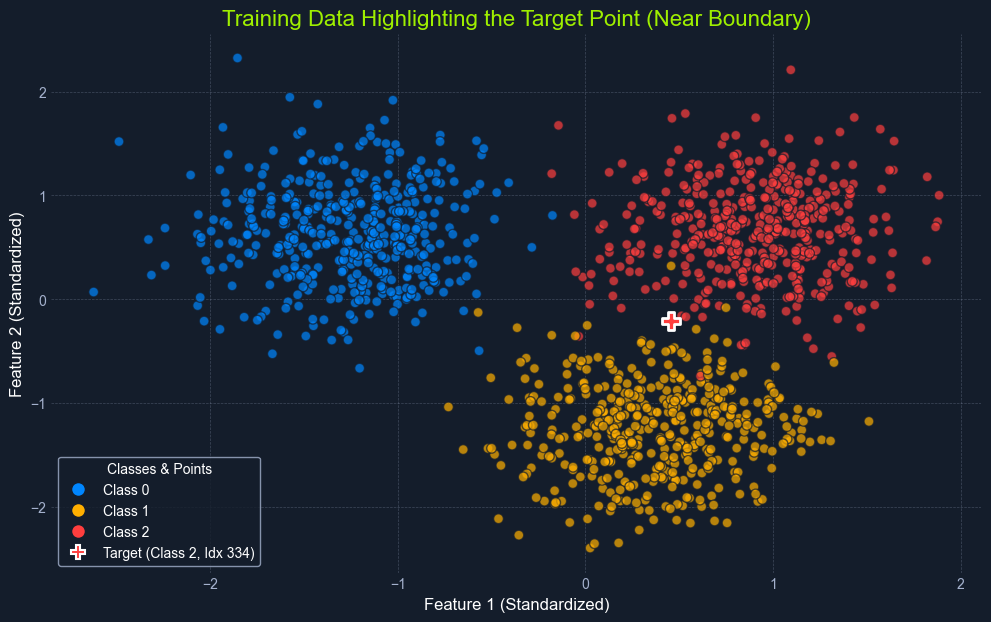

Found 420 Class 1 points in the training set.

Target Point Index: 334 (True Class 2)
Identified 12 closest Class 1 neighbors to perturb:
  Indices in X_train_3c: [1123  586 1214  555  596  785 1082 1231 1156  982 1122  385]
  Distances to target: [0.15673816 0.24632426 0.25281227 0.25915359 0.26472073 0.27666088
 0.28758147 0.29796257 0.31337957 0.31347495 0.31877829 0.36180067]

--- Calculating Perturbation Vector ---
Calculated unit push direction vector (normalized - (w0-w1)): [ 0.61974973 -0.78479951]
Perturbation magnitude (epsilon_cross): 0.4
Final perturbation vector (delta): [ 0.24789989 -0.31391981]

--- Applying Perturbations to Create Poisoned Dataset ---
  Neighbor Index 1123 (Label 0): Perturbed.
     Original f01 = -6.0744 (>0 expected), Perturbed f01 = -10.1036 (<0 expected)
  Neighbor Index 586 (Label 0): Perturbed.
     Original f01 = -5.1333 (>0 expected), Perturbed f01 = -9.1624 (<0 expected)
  Neighbor Index 1214 (Label 0): Perturbed.
     Original f01 = -5.7182 (>

In [46]:
try:
    X_train_poisoned, y_train_poisoned, perturbed_indices = perform_clean_label_attack(
        X_train,
        y_train,
        target_index,
        TARGET_CLASS,
        PERTURBING_CLASS,
        N_NEIGHBORS,
        EPSILON_CROSS,
        SEED,
    )
    print(f"\nAttack function executed. Poisoned data shape: {X_train_poisoned.shape}")
    print(f"Indices perturbed: {perturbed_indices}")

    print("\n--- Training Final Model on Poisoned Data ---")
    poisoned_model = OneVsRestClassifier(
        LogisticRegression(random_state=SEED, C=1.0, solver="liblinear")
    )
    poisoned_model.fit(X_train_poisoned, y_train_poisoned)
    print("Final model trained successfully on poisoned data.")

    attack_logic_successful = True
except Exception as e:
    print(
        f"\n{malware_red}Error during attack execution or poisoned model training:{white} {e}"
    )
    print("Cannot proceed to evaluation or submission.")
    attack_logic_successful = False
    # Assign placeholder values to allow subsequent cells to run without crashing immediately
    X_train_poisoned, y_train_poisoned, perturbed_indices = (
        X_train,
        y_train,
        np.array([]),
    )
    poisoned_model = None  # Indicate model training failed



--- Evaluating Poisoned Model ---
Target Point Evaluation (Index: 334):
  Original True Label:      2
  Poisoned Model Prediction: 2
  #ff3e3eFailure:#ffffff The poisoned model still correctly classified the target point as Class 2.

Overall Performance on Clean Test Set (for info):
  Poisoned Model Accuracy: 0.9833

Classification Report (Poisoned Model on Clean Test Data):
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       180
     Class 1       0.98      0.97      0.97       180
     Class 2       0.97      0.98      0.98       180

    accuracy                           0.98       540
   macro avg       0.98      0.98      0.98       540
weighted avg       0.98      0.98      0.98       540


--- Visualizing Poisoned Training Data ---


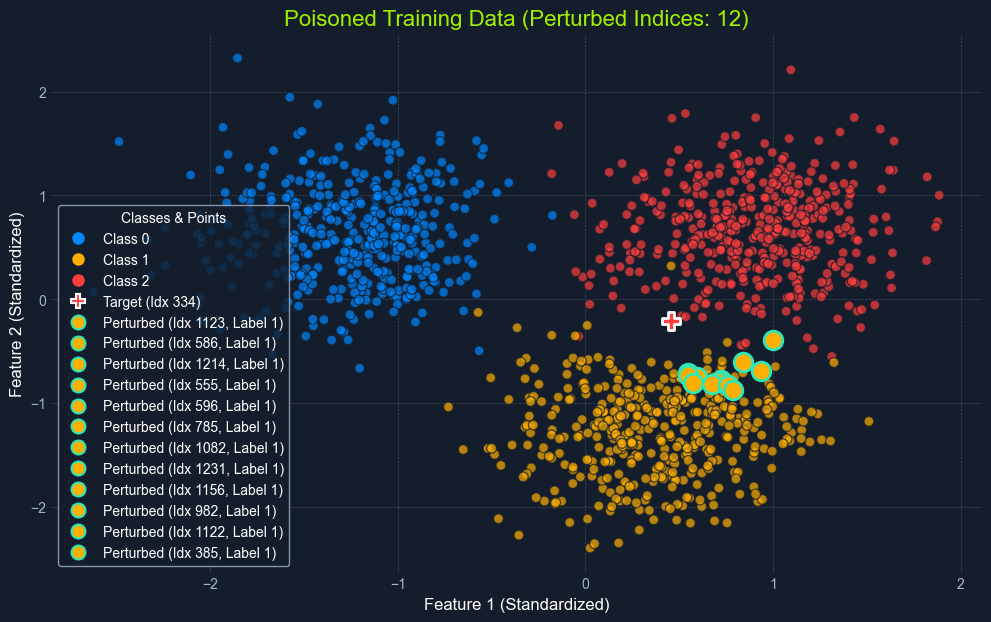


--- Visualizing Poisoned Model Decision Boundaries ---


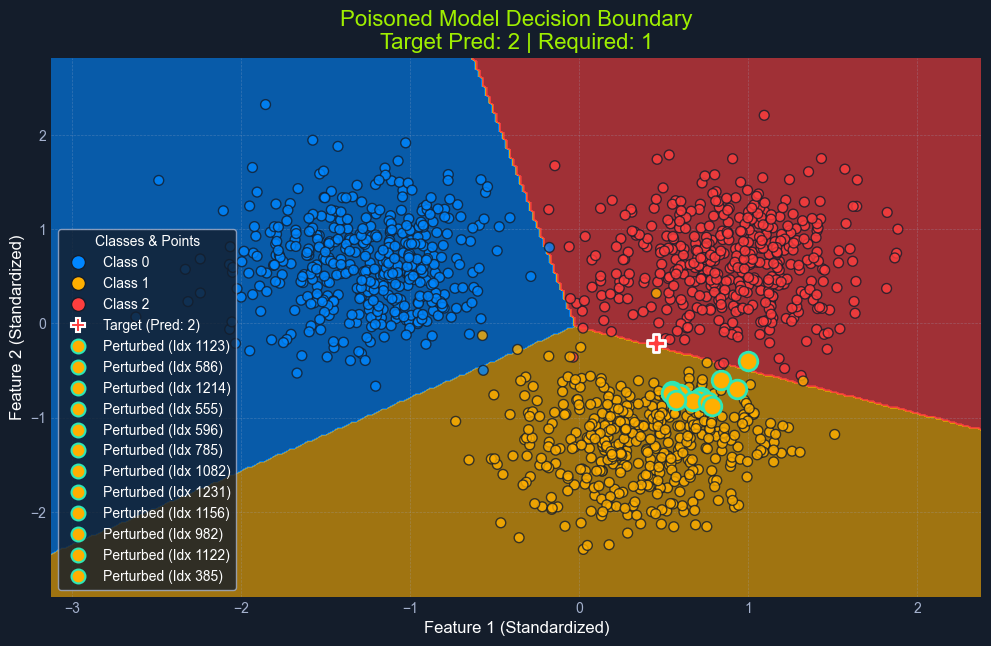

In [47]:
if attack_logic_successful and poisoned_model is not None:
    print("\n--- Evaluating Poisoned Model ---")

    # Check prediction for the target point
    X_target_reshaped = X_target_point.reshape(1, -1)
    target_pred_poisoned = poisoned_model.predict(X_target_reshaped)[0]

    print(f"Target Point Evaluation (Index: {target_index}):")
    print(f"  Original True Label:      {TARGET_CLASS}")
    print(f"  Poisoned Model Prediction: {target_pred_poisoned}")

    # Check if the misclassification matches the requirement
    attack_successful = target_pred_poisoned == MISCLASSIFY_AS_CLASS

    if attack_successful:
        print(
            f"  {htb_green}Success:{white} The poisoned model misclassified the target point as the required Class {MISCLASSIFY_AS_CLASS}."
        )
    else:
        if target_pred_poisoned == TARGET_CLASS:
            print(
                f"  {malware_red}Failure:{white} The poisoned model still correctly classified the target point as Class {target_pred_poisoned}."
            )
        else:
            print(
                f"  {nugget_yellow}Partial/Unexpected:{white} The poisoned model misclassified the target point as Class {target_pred_poisoned}, but NOT the required Class {MISCLASSIFY_AS_CLASS}."
            )

    # Evaluate overall accuracy on the clean test set (optional insight)
    try:
        y_pred_poisoned_test = poisoned_model.predict(X_test)
        poisoned_accuracy_test = accuracy_score(y_test, y_pred_poisoned_test)
        print(f"\nOverall Performance on Clean Test Set (for info):")
        print(f"  Poisoned Model Accuracy: {poisoned_accuracy_test:.4f}")
        print("\nClassification Report (Poisoned Model on Clean Test Data):")
        print(
            classification_report(
                y_test,
                y_pred_poisoned_test,
                target_names=[f"Class {i}" for i in range(3)],
            )
        )
    except Exception as e:
        print(
            f"\n{nugget_yellow}Warning:{white} Could not evaluate test set accuracy: {e}"
        )

    # --- Visualize Poisoned Data and Boundaries ---
    print("\n--- Visualizing Poisoned Training Data ---")
    # Highlight target and the points that were actually perturbed
    plot_data_multi(
        X_train_poisoned,
        y_train_poisoned,  # Labels are unchanged
        title=f"Poisoned Training Data (Perturbed Indices: {len(perturbed_indices)})",
        highlight_indices=[target_index] + perturbed_indices.tolist(),
        highlight_markers=["P"] + ["o"] * len(perturbed_indices),
        highlight_colors=[white]
        + [aquamarine] * len(perturbed_indices),  # Aquamarine for perturbed points
        highlight_labels=[f"Target (Idx {target_index})"]
        + [
            f"Perturbed (Idx {idx}, Label {PERTURBING_CLASS})"
            for idx in perturbed_indices
        ],
    )

    print("\n--- Visualizing Poisoned Model Decision Boundaries ---")
    plot_decision_boundary_multi(
        X_train_poisoned,  # Show poisoned points
        y_train_poisoned,
        poisoned_model,  # Use the poisoned model for boundaries
        title=f"Poisoned Model Decision Boundary\nTarget Pred: {target_pred_poisoned} | Required: {MISCLASSIFY_AS_CLASS}",
        highlight_indices=[target_index] + perturbed_indices.tolist(),
        highlight_markers=["P"] + ["o"] * len(perturbed_indices),
        highlight_colors=[white] + [aquamarine] * len(perturbed_indices),
        highlight_labels=[f"Target (Pred: {target_pred_poisoned})"]
        + [f"Perturbed (Idx {idx})" for idx in perturbed_indices],
    )

else:
    print(
        "\nSkipping evaluation and visualization due to errors in attack implementation or model training."
    )


In [48]:
# Extract weights and intercept from the successfully trained poisoned model
if attack_logic_successful and poisoned_model is not None:
    try:
        # For OvR, we need weights/intercepts from all base estimators
        # The evaluator expects a list of lists for weights and a list for intercepts
        weights_list = [est.coef_[0].tolist() for est in poisoned_model.estimators_]
        intercept_list = [est.intercept_[0] for est in poisoned_model.estimators_]
        print("Extracted weights and intercepts from the poisoned model.")
        print(
            f"Weights shape (list of lists): ({len(weights_list)}, {len(weights_list[0]) if weights_list else 0})"
        )
        print(f"Intercept shape (list): ({len(intercept_list)})")
        submission_ready = True
    except Exception as e:
        print(
            f"{malware_red}Error:{white} Failed to extract parameters from poisoned model: {e}"
        )
        submission_ready = False
else:
    print(
        "Skipping parameter extraction because the model was not trained successfully."
    )
    submission_ready = False


Extracted weights and intercepts from the poisoned model.
Weights shape (list of lists): (3, 2)
Intercept shape (list): (3)


In [49]:
# Replace <EVALUATOR_IP> and <PORT> with the correct values for the lab environment.
# Example: evaluator_base_url = "http://10.10.10.5:5000"
# evaluator_base_url = "http://<EVALUATOR_IP>:<PORT>"
evaluator_base_url = "http://94.237.57.57:36643"

# --- Health Check ---
health_check_url = f"{evaluator_base_url}/health"
print(f"Checking evaluator health at: {health_check_url}")

if "<EVALUATOR_IP>" in evaluator_base_url:
    print(f"\n{nugget_yellow}--- WARNING ---")
    print(
        "Please update the 'evaluator_base_url' variable with the correct IP and Port before running!"
    )
    print("----------------{white}")
else:
    try:
        response = requests.get(health_check_url, timeout=10)
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)
        health_status = response.json()
        print("\n--- Health Check Response ---")
        print(f"Status: {health_status.get('status', 'N/A')}")
        print(f"Message: {health_status.get('message', 'No message received.')}")
        if health_status.get("status") != "healthy":
            print(
                f"\n{nugget_yellow}Warning:{white} Evaluator service reported an unhealthy status. Submission might fail."
            )
    except requests.exceptions.ConnectionError:
        print(
            f"\n{malware_red}Connection Error:{white} Could not connect to {health_check_url}."
        )
        print(
            "Please check the evaluator URL (IP/Port) and ensure the Docker container is running."
        )
    except requests.exceptions.Timeout:
        print(
            f"\n{malware_red}Timeout Error:{white} The request to {health_check_url} timed out."
        )
    except requests.exceptions.RequestException as e:
        print(f"\n{malware_red}Error during health check:{white} {e}")
    except json.JSONDecodeError:
        print(
            f"\n{malware_red}Error:{white} Could not decode JSON response from health check."
        )
        print(f"Raw status: {response.status_code}, Raw text: {response.text}")
    except Exception as e:
        print(
            f"\n{malware_red}An unexpected error occurred during health check:{white} {e}"
        )

# --- Submission ---
evaluator_url = f"{evaluator_base_url}/evaluate"
print(f"\nAttempting submission to: {evaluator_url}")

if "<EVALUATOR_IP>" in evaluator_base_url:
    print(f"\n{nugget_yellow}--- WARNING ---")
    print("Update 'evaluator_base_url' with the correct IP and Port before submitting!")
    print("----------------{white}")
elif not submission_ready:
    print(
        f"\n{malware_red}Submission aborted:{white} Model parameters were not extracted successfully."
    )
else:
    # Prepare payload
    payload = {"weights": weights_list, "intercept": intercept_list}
    # print(f"Payload preview: {json.dumps(payload, indent=2)[:500]}...")

    try:
        response = requests.post(evaluator_url, json=payload, timeout=30)
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)
        result = response.json()

        print("\n--- Evaluator Response ---")
        if result.get("success"):
            print(f"{htb_green}Attack Successful!{white}")
            # Accuracy reported by server might be on the *poisoned* test set or a hidden one
            print(f"Accuracy reported by server: {result.get('accuracy', 'N/A'):.4f}")
            print(f"Target Point Check: {result.get('message', 'No message.')}")
            print(f"{htb_green}Flag: {result.get('flag', 'FLAG_NOT_RETURNED')}{white}")
        else:
            print(f"{malware_red}Evaluation Failed.{white}")
            accuracy_val = result.get("accuracy")
            accuracy_str = f"{accuracy_val:.4f}" if accuracy_val is not None else "N/A"
            print(f"Accuracy reported by server: {accuracy_str}")
            print(f"Message: {result.get('message', 'No specific message.')}")
            print("\nHints: Did your attack successfully misclassify the target point?")
            print(
                "Did you perturb the correct neighbors? Is epsilon_cross appropriate?"
            )
            print("Did you submit parameters for a 3-class OvR model?")

    except requests.exceptions.ConnectionError:
        print(
            f"\n{malware_red}Connection Error:{white} Could not connect to {evaluator_url}."
        )
        print("Check the evaluator URL and ensure the Docker container is running.")
    except requests.exceptions.Timeout:
        print(
            f"\n{malware_red}Timeout Error:{white} The request to {evaluator_url} timed out."
        )
    except requests.exceptions.RequestException as e:
        # This catches HTTPError (4xx, 5xx) as well
        print(f"\n{malware_red}Error during submission:{white} {e}")
        try:
            # Try to get more info from the response if available
            error_details = response.json()
            print(f"Server responded with: {error_details}")
        except (AttributeError, json.JSONDecodeError):
            if hasattr(response, "text"):
                print(f"Raw response content: {response.text}")
            else:
                print("(No response content available)")
    except json.JSONDecodeError:
        print(
            f"\n{malware_red}Error:{white} Could not decode JSON response from evaluator."
        )
        print(f"Raw status: {response.status_code}, Raw text: {response.text}")
    except Exception as e:
        print(
            f"\n{malware_red}An unexpected error occurred during submission:{white} {e}"
        )


Checking evaluator health at: http://94.237.57.57:36643/health

--- Health Check Response ---
Status: healthy
Message: Evaluator API is running.

Attempting submission to: http://94.237.57.57:36643/evaluate

--- Evaluator Response ---
#ff3e3eEvaluation Failed.#ffffff
Accuracy reported by server: 0.9833
Message: Target point (Index 334, True Class 2) was predicted as 2, but required prediction was 1.

Hints: Did your attack successfully misclassify the target point?
Did you perturb the correct neighbors? Is epsilon_cross appropriate?
Did you submit parameters for a 3-class OvR model?
